In [22]:
import glob
import torch
import segmentation_models_pytorch as smp
from torchsummary import summary
import numpy as np
from torchsummary import summary
import numpy as np
from torchsummary import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

torch.cuda.is_available()

def get_sorted_data_paths(split):
    image_paths = sorted(glob.glob("../../data/" + split + "/images/*.tif"))
    masks_paths = sorted(glob.glob("../../data/" + split + "/masks/*.tif"))
    lidar_paths = sorted(glob.glob("../../data/" + split + "/lidar/*.tif"))

    return image_paths, lidar_paths, masks_paths


image_paths, lidar_paths, masks_paths = get_sorted_data_paths("train")
image_paths_val, lidar_paths_val, masks_paths_val = get_sorted_data_paths("validation")


Total Images:  7000
Total Lidars:  7000
Total Masks:  7000


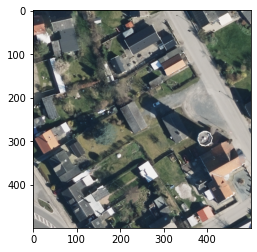

In [23]:
img = Image.open(image_paths[1])
mask = Image.open(masks_paths[1])

plt.imshow(img)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

print('Total Images: ', len(image_paths))
print('Total Lidars: ', len(lidar_paths))
print('Total Masks: ', len(masks_paths))


In [24]:
class DroneDataset(Dataset):

    def __init__(self, img_paths, mask_paths, mean, std, size=(512, 512), transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mean = mean
        self.std = std
        self.size = size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.size)

        mask = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask[mask == 255] = 1
        mask = cv2.resize(mask, self.size)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        return img, mask


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast(
                         (0, 0.5), (0, 0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

# datasets
train_set = DroneDataset(image_paths, masks_paths, mean,
                         std, size=(512, 512), transform=t_train)
                         
val_set = DroneDataset(image_paths_val, masks_paths_val,
                       mean, std, size=(512, 512), transform=t_val)

# dataloader
batch_size = 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)


In [25]:
import torch
import torch.nn as nn


class batchnorm_relu(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        return x


class residual_block(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        """ Convolutional layer """
        self.b1 = batchnorm_relu(in_c)
        self.c1 = nn.Conv2d(in_c, out_c, kernel_size=3,
                            padding=1, stride=stride)
        self.b2 = batchnorm_relu(out_c)
        self.c2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=1)

        """ Shortcut Connection (Identity Mapping) """
        self.s = nn.Conv2d(in_c, out_c, kernel_size=1,
                           padding=0, stride=stride)

    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)
        x = self.b2(x)
        x = self.c2(x)
        s = self.s(inputs)

        skip = x + s
        return skip


class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.upsample = nn.Upsample(
            scale_factor=2, mode="bilinear", align_corners=True)
        self.r = residual_block(in_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.r(x)
        return x


class build_resunet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder 1 """
        self.c11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(3, 64, kernel_size=1, padding=0)

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(256, 512, stride=2)

        """ Decoder """
        self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        output = self.sigmoid(output)

        return output


inputs = torch.randn((1, 3, 512, 512))
model = build_resunet()
y = model(inputs)
print(y.shape)


torch.Size([1, 1, 512, 512])


In [26]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):  # loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(
                    true_class, true_label).sum().float().item()
                union = torch.logical_or(
                    true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        # training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # training phase
            
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
            # forward
            output = model(image)
            loss = criterion(output, mask)
            # evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            # backward
            loss.backward()
            optimizer.step()  # update weight
            optimizer.zero_grad()  # reset gradient

            # step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            # validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    # reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    output = model(image)
                    # evaluation metrics
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    # loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            # calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(
                    min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(
                        model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            # iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(
                      running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss': train_losses, 'val_loss': test_losses,
               'train_miou': train_iou, 'val_miou': val_iou,
               'train_acc': train_acc, 'val_acc': val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time() - fit_time)/60))
    return history


In [ ]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)